# Project Milestone One: Gathering your Team, Understanding the Problem,  Exploring the Data

#### Due: Midnight on July 20th (with 2-hour grace period)

#### There will be no late period on this homework, as we need to start manual grading immediately! 



### What We Will Do in This Milestone Assignment

1. You will convene your team and fill out the Team Contract (in the Homework Repo), to be submitted to Gradescope.
2. You must select a team leader for the purpose of submitting this notebook, after the team collaborates to complete the assignment. This <a href=https://guides.gradescope.com/hc/en-us/articles/21863861823373-Adding-Group-Members-to-a-Submission>link</a> describes how to add group members to your leader's submission. 
3. At the conclusion of your work on this Milestone, you will complete an Individual Evaluation of your team's work (in the Homework Repo) and upload it *individually* to Gradescope.
4. We will follow a simplified version of the **Machine Learning Project Checklist** in Appendix A in our textbook *Hands-On Machine Learning* (pp.779):  

>Part 1:	Frame the problem and look at the big picture  
Part 2: Download and perform preliminary exploration of the data  
Part 3: Clean the Data: Drop, Impute, and Encode   
Part 4: Explore Feature Relationships  
Part 5: Investigate Feature Engineering options to better expose the underlying data patterns  

### The Dataset

All teams will use the same dataset. It is a smaller version of the Zillow housing dataset that was used in the
Zillow Million Dollar Prize which ran on Kaggle in 2017 (sorry, the contest is closed, so you can't win any money
with this project!).  We will try to predict the assessed tax value (`'taxvaluedollarcnt'`) of the property from a large collection
of descriptors. Some features are closely related and some are obviously useless.  There are potential outliers and also quite a few missing values. 

This is a good example of a dataset which has not been predigested for you on Kaggle, and should give you a good chance to
try all the various tools in your toolbox!


In [136]:
# =============================
# Useful Imports
# =============================

# Standard Libraries
import os
import time
import math
import io
import zipfile
import requests
from urllib.parse import urlparse
from itertools import chain, combinations

# Data Science Libraries
import numpy as np
import pandas as pd
import seaborn as sns

# Visualization
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.ticker as mticker  # Optional: Format y-axis labels as dollars

# Scikit-learn (Machine Learning)
from sklearn.model_selection import (
    train_test_split, 
    cross_val_score, 
    GridSearchCV, 
    RandomizedSearchCV, 
    RepeatedKFold
)
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.feature_selection import SequentialFeatureSelector, f_regression, SelectKBest
from sklearn.datasets import make_regression
from sklearn.ensemble import BaggingRegressor, RandomForestRegressor, GradientBoostingRegressor

# Kaggle and Progress Tracking
from tqdm import tqdm

# =============================
# Global Variables
# =============================
random_state = 42

# =============================
# Utility Functions
# =============================

# Format y-axis labels as dollars with commas (optional)
def dollar_format(x, pos):
    return f'${x:,.0f}'

# Convert seconds to HH:MM:SS format
def format_hms(seconds):
    return time.strftime("%H:%M:%S", time.gmtime(seconds))



## Prelude: Download the Zillow Housing Dataset 

The code cell below will load the dataset for you.    

> **Notice that before downloading, this cell first checks whether the files already exist.** 

For a detailed description of the dataset features, please refer to  **Appendix 1** below. 

**Note:** Do **not** perform a train/test split for this milestone (unlike HOML suggests), since you need to do the split **after** any data preparation and feature engineering. You can wait until Milestone 2 to do the split. 

In [137]:

url = "https://www.cs.bu.edu/fac/snyder/cs505/Data/zillow_dataset.csv"

filename = os.path.basename(urlparse(url).path)

if not os.path.exists(filename):
    try:
        print("Downloading the file...")
        response = requests.get(url)
        response.raise_for_status()  # Raise an error for bad status codes
        with open(filename, "wb") as f:
            f.write(response.content)
        print("File downloaded successfully.")
    except requests.exceptions.RequestException as e:
        print(f"Error downloading the file: {e}")
else:
    print("File already exists. Skipping download.")

df = pd.read_csv(filename)

File already exists. Skipping download.


## Part 1: Frame the problem and look at the big picture [3 pts]

This part is a bit vague, since this project is not taking place in an actual business, but for the sake of exercizing all the steps, **pretend** that you are working at Zillow as a data analyst and are given this dataset and asked to
- Analyze and understand the data; 
- Create a regression model;
- Give a presentation to the marketing team about your results.  

#### **1 Discussion:** 

AFTER doing your EDA, come back and answer each of the following 3 questions in a *concise and informative paragraph between the lines;* you may wish to use your own business or home-buying experience, or to do some online research about the issues before you propose your ideas. (Don't stress about this, but *humor your professor and give it your best shot!*)


**1.1:**  What is the objective of this project in business terms?

Objective is to predict or estimate tax value of a property based on the features of the property. 


**1.2:**  How will your solution be used?


By predicting what the tax value of a property is, it can help investors finding undervalued or overvalued properties. It can hep property buyers to make better choices and finding properties that are worth its value. 

**1.3:**  How should success (or failure) be measured?
A success for someone using the predicted results would be that the property buyer gets a good deal on a property. It helps them make informed decisions and save money or get better deals. 

The objective of this project is to build a predictive model that would estimate the tax value of the housing properties based on various property features such as number of bedrooms, square footage of the property, has a pool, and other valuable features. In business terms, this model would allow investors and buyers to make data driven decisions by identifying under valued and over valued properties. This will help them make better choices and optimizing their budget or pricing. The solution can be used to guide these property choices, identify good deals, and assess future market value. Success in terms of the modeling can be measured by R squared score or MSE. The model should also be able to generalize to new data and prove usefullness in identifying properties that differ significantly from their predicted values.

## Part 2: Download and perform preliminary exploration of the data [4 pts]

### Part 2.A: Load the data into a dataframe and study each feature/column and its characteristics:
- Name
- Type (categorical, int/float, text, etc.)
- Apparent usefulness for the task
- Approximate % of missing values
- How many unique values

**Note:** The **target** is the last column `'taxvaluedollarcnt'` -- pay particular attention to this during the EDA process. 
  
Hint: Just use `.head()`, `.info()`, and `.nunique()`.

In [138]:
df.head()

,parcelid,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,buildingclasstypeid,buildingqualitytypeid,calculatedbathnbr,decktypeid,...,yardbuildingsqft17,yardbuildingsqft26,yearbuilt,numberofstories,fireplaceflag,assessmentyear,taxdelinquencyflag,taxdelinquencyyear,censustractandblock,taxvaluedollarcnt
0,14297519,NaN,NaN,NaN,3.5,4.0,NaN,NaN,3.5,NaN,...,NaN,NaN,1998.0,NaN,NaN,2016.0,NaN,NaN,6.059063e+13,1023282.0
1,17052889,NaN,NaN,NaN,1.0,2.0,NaN,NaN,1.0,NaN,...,NaN,NaN,1967.0,1.0,NaN,2016.0,NaN,NaN,6.111001e+13,464000.0
2,14186244,NaN,NaN,NaN,2.0,3.0,NaN,NaN,2.0,NaN,...,NaN,NaN,1962.0,1.0,NaN,2016.0,NaN,NaN,6.059022e+13,564778.0
3,12177905,NaN,NaN,NaN,3.0,4.0,NaN,8.0,3.0,NaN,...,NaN,NaN,1970.0,NaN,NaN,2016.0,NaN,NaN,6.037300e+13,145143.0
4,10887214,1.0,NaN,NaN,3.0,3.0,NaN,8.0,3.0,NaN,...,NaN,NaN,1964.0,NaN,NaN,2016.0,NaN,NaN,6.037124e+13,119407.0


In [139]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 77613 entries, 0 to 77612
Data columns (total 55 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   parcelid                      77613 non-null  int64  
 1   airconditioningtypeid         25007 non-null  float64
 2   architecturalstyletypeid      207 non-null    float64
 3   basementsqft                  50 non-null     float64
 4   bathroomcnt                   77579 non-null  float64
 5   bedroomcnt                    77579 non-null  float64
 6   buildingclasstypeid           15 non-null     float64
 7   buildingqualitytypeid         49809 non-null  float64
 8   calculatedbathnbr             76963 non-null  float64
 9   decktypeid                    614 non-null    float64
 10  finishedfloor1squarefeet      6037 non-null   float64
 11  calculatedfinishedsquarefeet  77378 non-null  float64
 12  finishedsquarefeet12          73923 non-null  float64
 13  f

In [140]:
df.nunique()

parcelid                        77414
airconditioningtypeid               5
architecturalstyletypeid            5
basementsqft                       43
bathroomcnt                        22
bedroomcnt                         16
buildingclasstypeid                 2
buildingqualitytypeid              12
calculatedbathnbr                  21
decktypeid                          1
finishedfloor1squarefeet         1787
calculatedfinishedsquarefeet     4972
finishedsquarefeet12             4868
finishedsquarefeet13               13
finishedsquarefeet15             1724
finishedsquarefeet50             1807
finishedsquarefeet6               350
fips                                3
fireplacecnt                        5
fullbathcnt                        13
garagecarcnt                       14
garagetotalsqft                   839
hashottuborspa                      1
heatingorsystemtypeid              10
latitude                        64038
longitude                       62461
lotsizesquar

In [141]:
# identify percentage of missing values
percent_missing = df.isnull().mean() * 100
percent_missing = percent_missing.sort_values(ascending= False)
percent_missing



buildingclasstypeid             99.980673
finishedsquarefeet13            99.945885
basementsqft                    99.935578
storytypeid                     99.935578
yardbuildingsqft26              99.909809
fireplaceflag                   99.778388
architecturalstyletypeid        99.733292
typeconstructiontypeid          99.712677
finishedsquarefeet6             99.502661
pooltypeid10                    99.400874
decktypeid                      99.208895
poolsizesum                     98.880342
pooltypeid2                     98.616211
hashottuborspa                  98.017085
yardbuildingsqft17              96.916754
taxdelinquencyyear              96.263513
taxdelinquencyflag              96.263513
finishedsquarefeet15            96.099880
finishedsquarefeet50            92.221664
finishedfloor1squarefeet        92.221664
fireplacecnt                    89.320088
threequarterbathnbr             86.978985
pooltypeid7                     80.571554
poolcnt                         79

#### **2.A Discussion:** Answer the following questions.

**2.A.1:**  Which features are categorical?

The columns 'hashottuborspa', 'propertycountylandusecode', 'propertyzoningdesc', 'fireplaceflag', and 'taxdelinquencyflag' columns are categorical. Some of them are boolean whith True, False, and blank values or they are string columns with codes.

In [142]:
# identify categorical columns
cat = df.select_dtypes(include = ["object"]).columns
print(cat)

Index(['hashottuborspa', 'propertycountylandusecode', 'propertyzoningdesc',
       'fireplaceflag', 'taxdelinquencyflag'],
      dtype='object')


**2.A.2:**  Are there any features which appear at first glance to be **useless** for the business purpose of this project and should be deleted?  Give examples and describe your reasoning briefly. 

The following features appear useless at first glance : pooltypeid10, pooltypeid2, and pooltypeid7 because it seems 1 to 1 with poolcnt and these features are probably strongly correlated to one another because they are very simliar. It provides more detail into the type of pool that the property has, so we will need to evaluate its use further into the eda. 


The columns 'propertyzoningdesc' and 'propertycountrylandusecode' may be difficult to interpret because we dont' know what the codes mean and how they relate to the property.
Some of the ID columns are also difficult to interpret because we're not sure what these IDs actually mean.
 

**2.A.3:**  Are there any features which appear to be **useless** because of the percentage of missing values?  If so, give an example. 

There are a lot of features that have 'null' or 'blank' values so we have to be careful if those are truly missing values or just 'blank' because they are values of 0.
The column 'architecturalstyletypeid' has 77406 missing values and assuming that each property would have a archiectural style it doesn't make sense for that many missing values and this feature looks useless.
The column 'airconditioningtypeid' has 52606 missing values and since not every property would have an air conditioning, we would have to decide if blank values mean there is no air conditioning therefore there is no air conditioning type or if these are truely missing values for properties with air conditioning.
Other columns with more than 99% missing values are : buildingclassstypeid, finishedsquarefeet13, basementsqft, storytypeid, yardbuildingsqft26, fireplaceflag, architecturalstyletypeid, typeconstructiontypeid, finishedsquarefeet6, pooltypeid10, and decktypeid. 


In [143]:
high_missing = percent_missing[percent_missing > 99]
high_missing

buildingclasstypeid         99.980673
finishedsquarefeet13        99.945885
basementsqft                99.935578
storytypeid                 99.935578
yardbuildingsqft26          99.909809
fireplaceflag               99.778388
architecturalstyletypeid    99.733292
typeconstructiontypeid      99.712677
finishedsquarefeet6         99.502661
pooltypeid10                99.400874
decktypeid                  99.208895
dtype: float64

**2.A.4:**  Are there any features which appear to be **useless** because of the number of unique values?  If so, give an example. 

The column 'assessmentyear' has 1 unique value of '2016' for all rows so its useless. Same for decktypeid, has 1 value of 66.

In [144]:
df['decktypeid'].value_counts()

decktypeid
66.0    614
Name: count, dtype: int64

In [145]:
df['assessmentyear'].value_counts()

assessmentyear
2016.0    77579
Name: count, dtype: int64

### Part 2.B: Exploratory Data Analysis (EDA) -- Feature-Level Visualization  

- To get an overview, generate histograms for all features using `df.hist()`  (Hint: increase the figsize and set the layout to `(-1,m)` to get  `m` columns and as many rows as necessary.)
- Generate individual visualizations for the **target and three (3)** other interesting-looking features in the dataset (i.e., a total of 4):  
    - Use appropriate plot types (e.g., histograms and boxplots for numerical features, bar plots for categorical features) to understand distributions and identify potential outliers for these three.
    - Use as many code cells as you need, and give comments describing what each cell does.
    - Answer the discussion question posed (you should choose 3 features for which you can say something interesting in the discussion).  

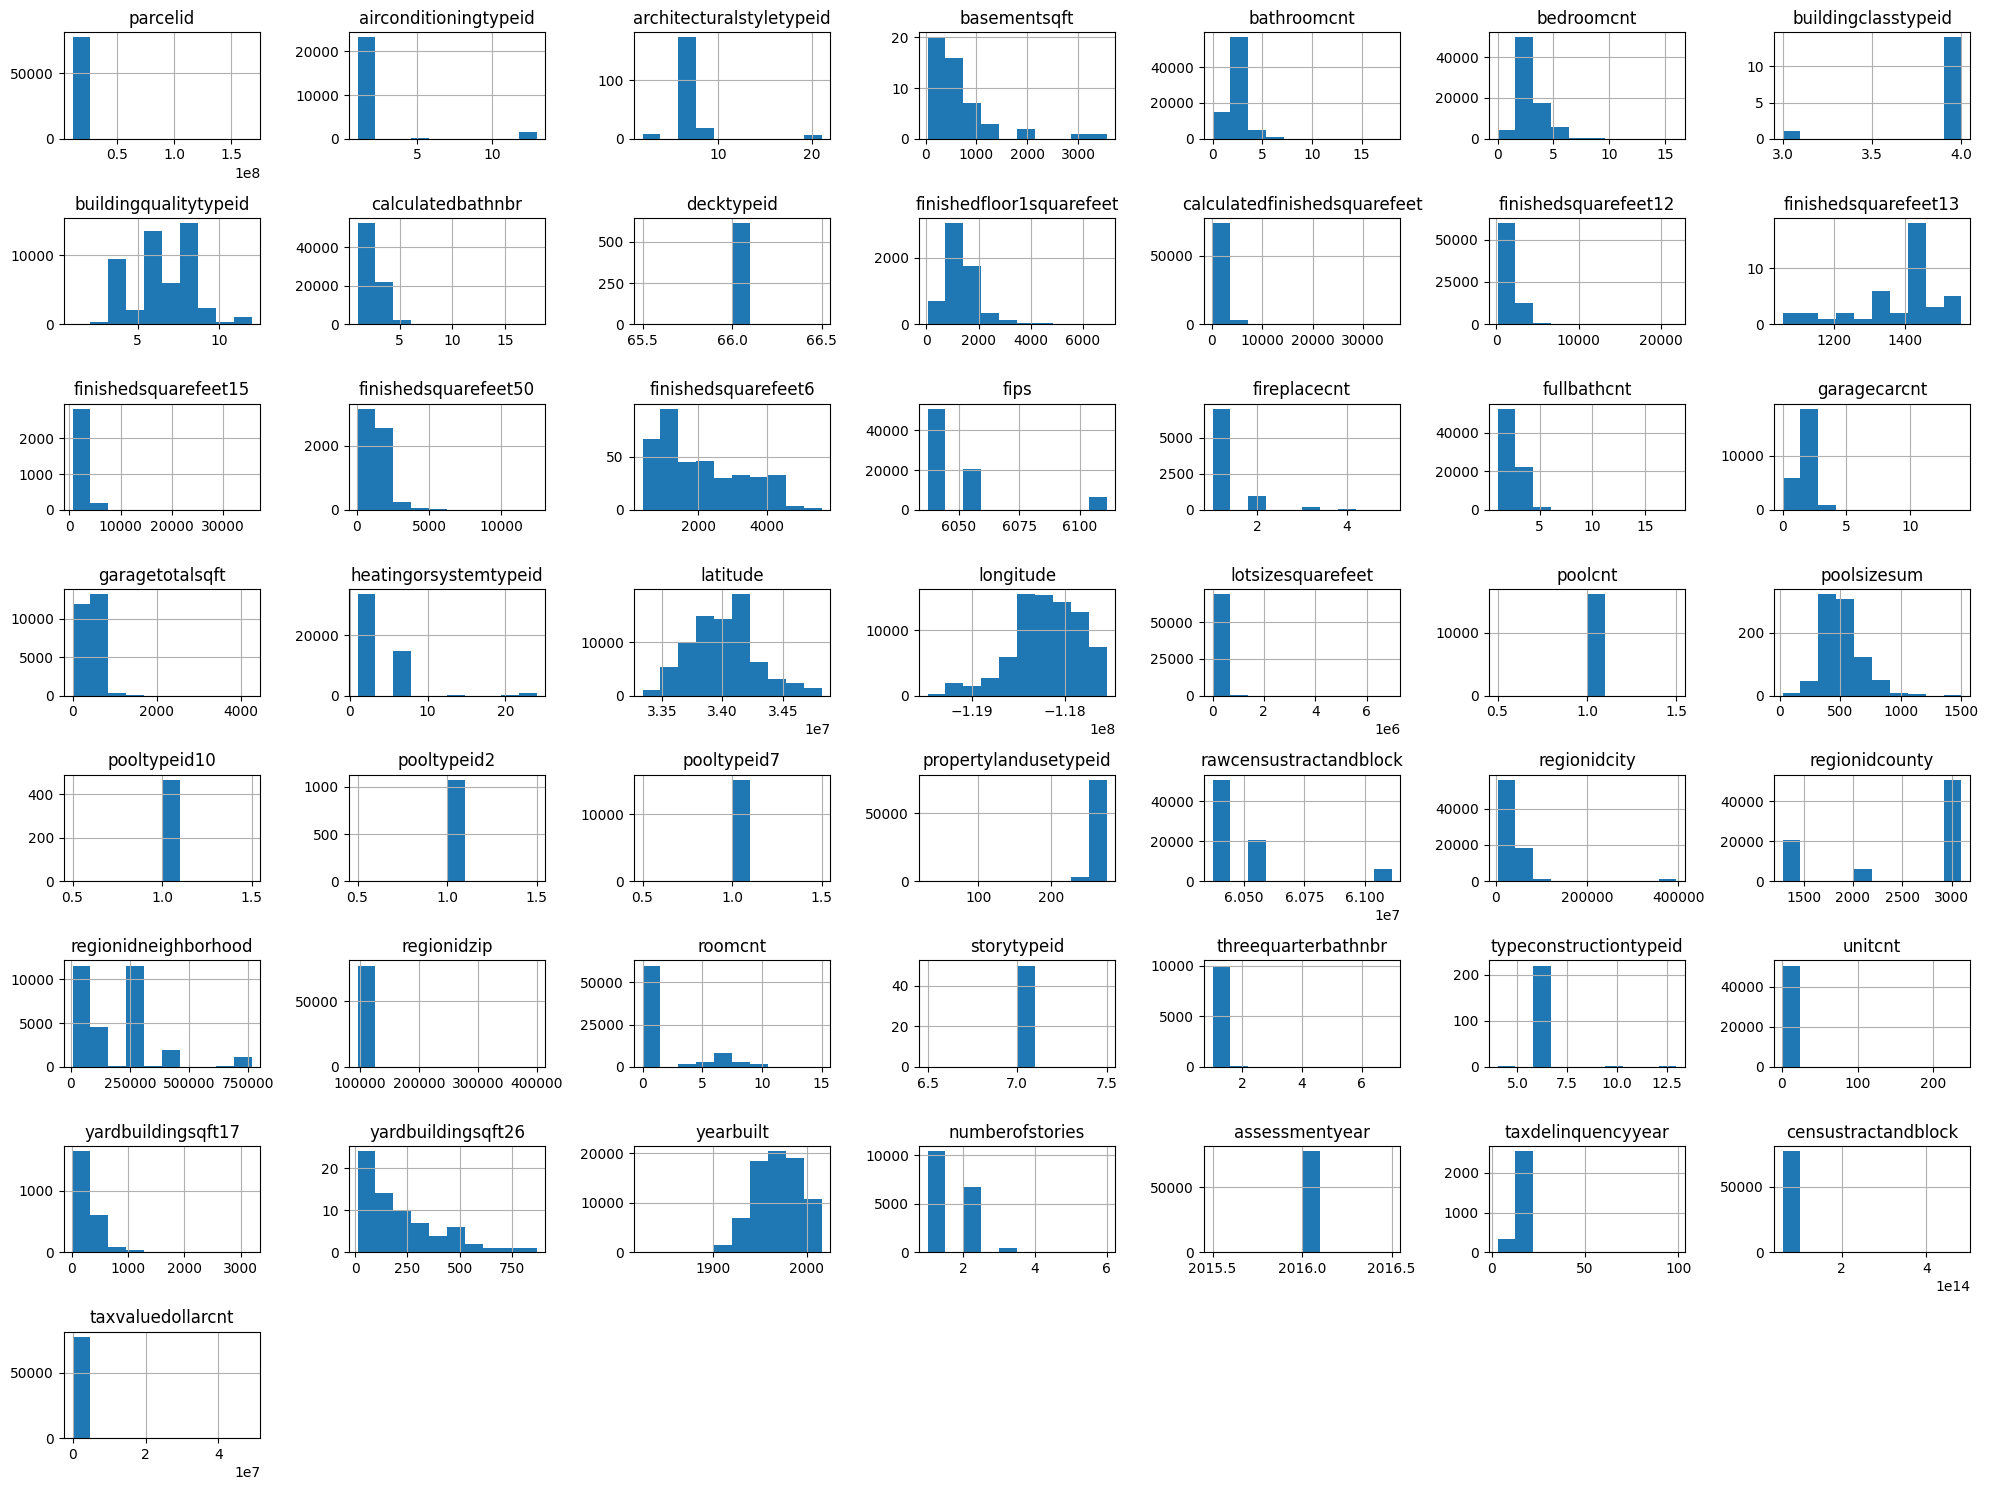

In [146]:
df.hist(figsize=(20, 15)) 
plt.tight_layout()
plt.show()

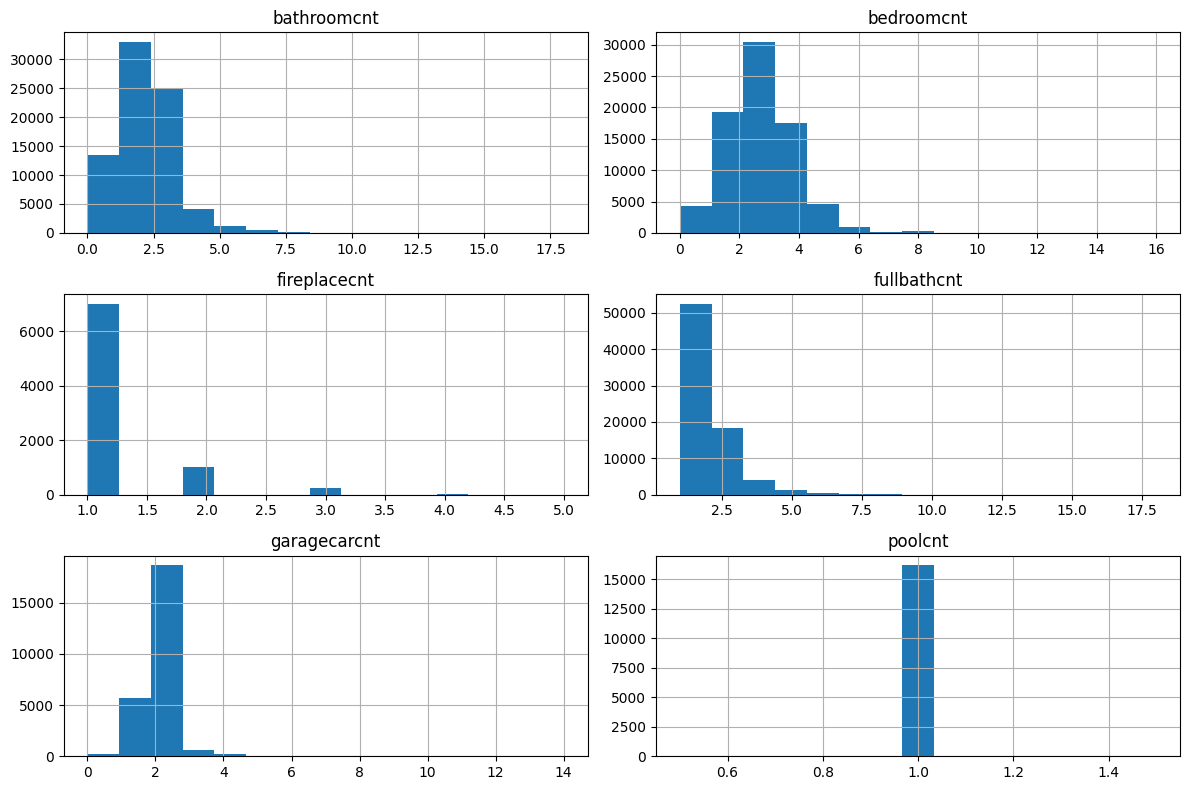

In [147]:
# closer look at the count based features and adjusting the bin size
cols = ['bathroomcnt', 'bedroomcnt', 'fireplacecnt',
        'fullbathcnt', 'garagecarcnt', 'poolcnt']

df[cols].hist(bins=15, figsize=(12, 8))
plt.tight_layout()
plt.show()

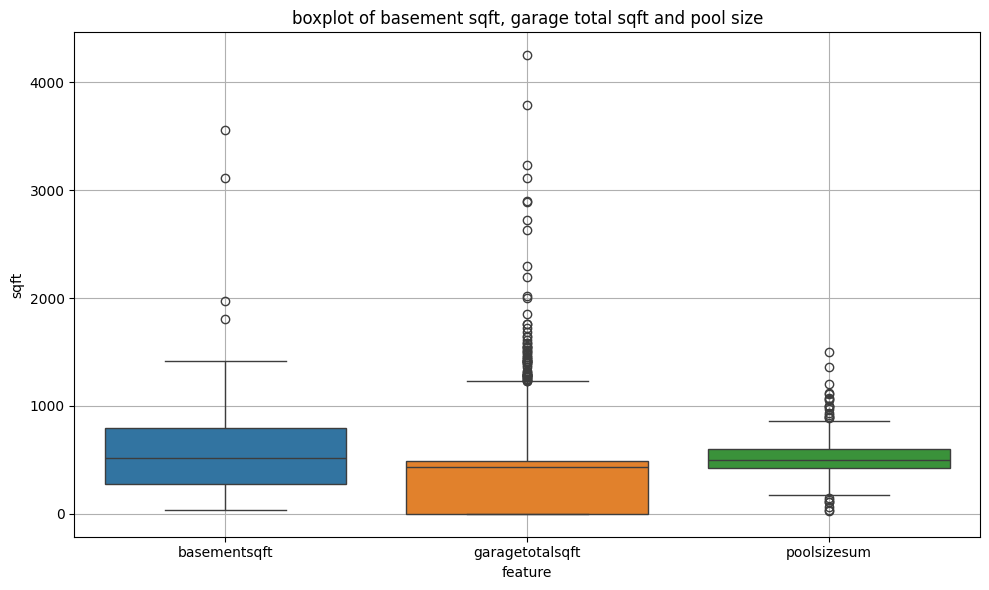

In [148]:
# box plots of 3 other non-target features 

features = ['basementsqft', 'garagetotalsqft', 'poolsizesum']
subset = df[features]

plt.figure(figsize=(10, 6))
sns.boxplot(data=subset)
plt.title('boxplot of basement sqft, garage total sqft and pool size')
plt.ylabel('sqft')
plt.xlabel('feature')
plt.grid(True)
plt.tight_layout()
plt.show()

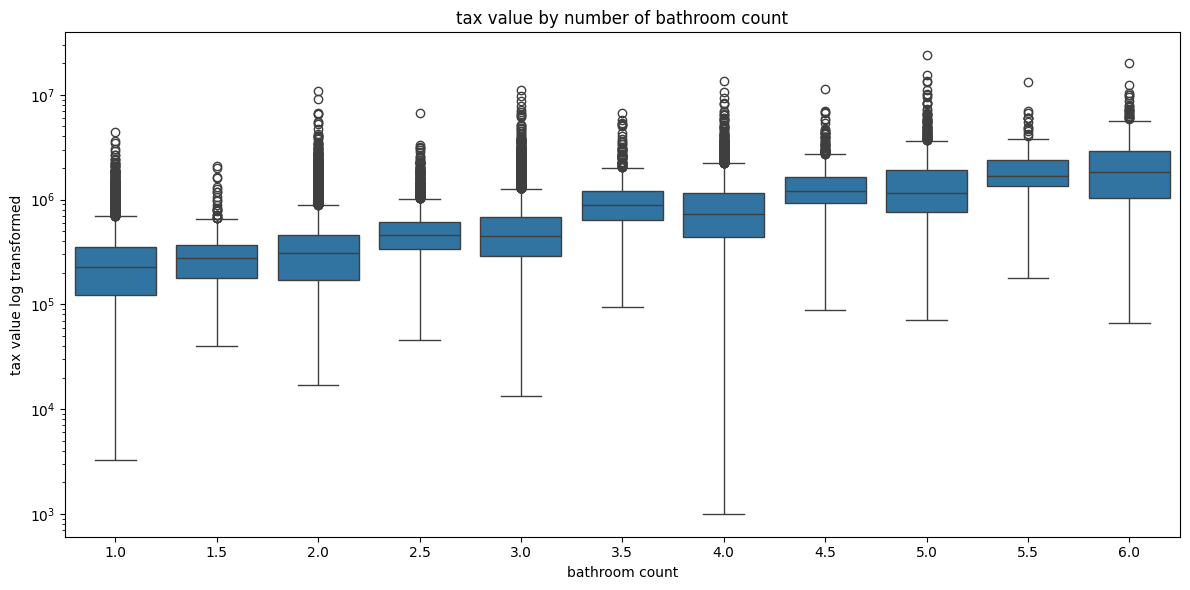

In [149]:
# box plots of bathroomcnt by tax value
# filtering for bathroom values between 0 and 6

filtered = df[(df['bathroomcnt'] > 0) & (df['bathroomcnt'] <= 6)]

plt.figure(figsize=(12, 6))
sns.boxplot(data=filtered, x='bathroomcnt', y='taxvaluedollarcnt')
plt.yscale('log')  
plt.title('tax value by number of bathroom count')
plt.xlabel('bathroom count')
plt.ylabel('tax value log transformed')
plt.tight_layout()
plt.show()



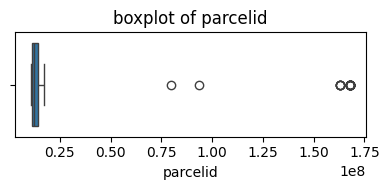

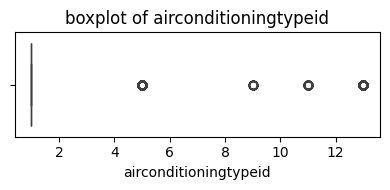

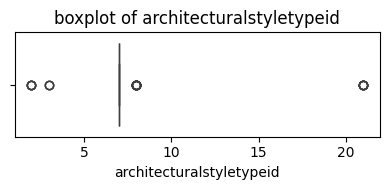

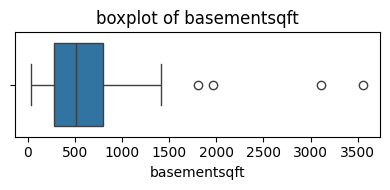

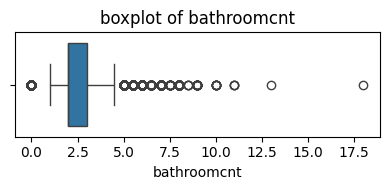

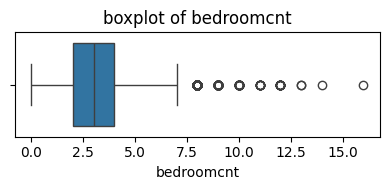

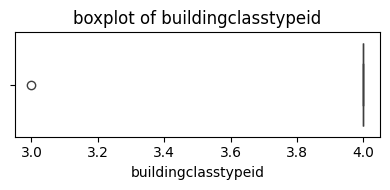

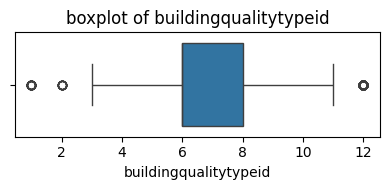

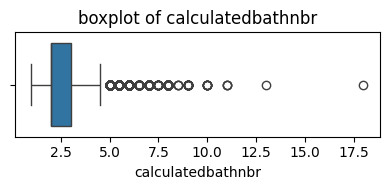

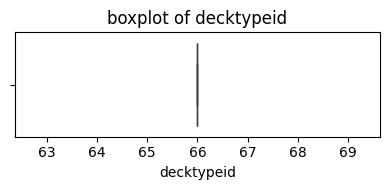

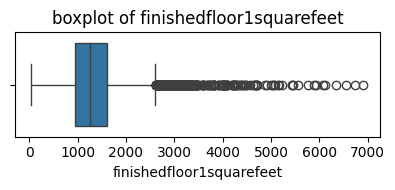

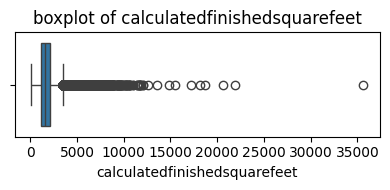

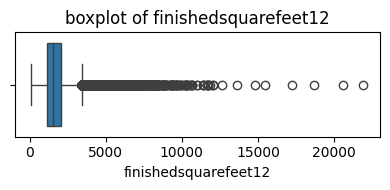

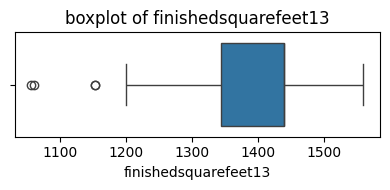

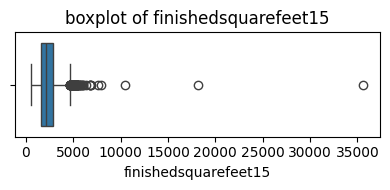

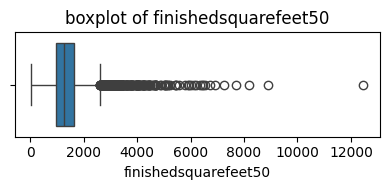

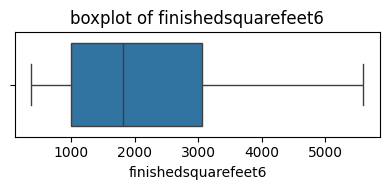

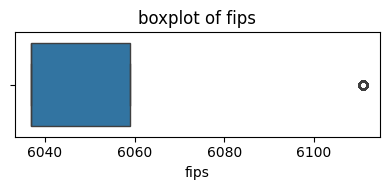

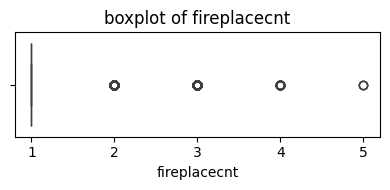

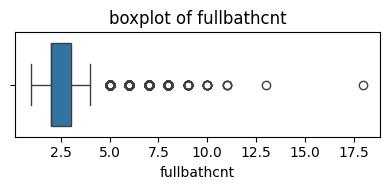

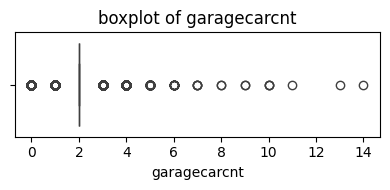

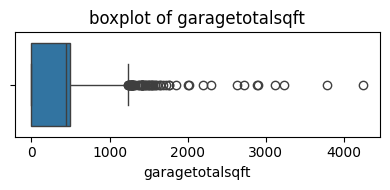

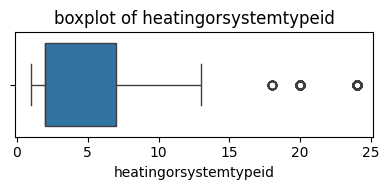

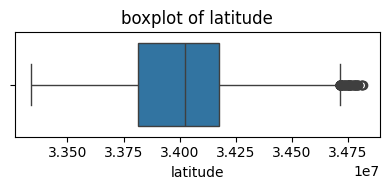

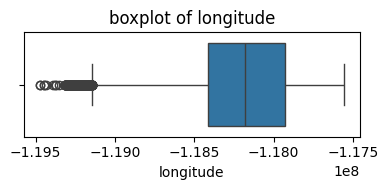

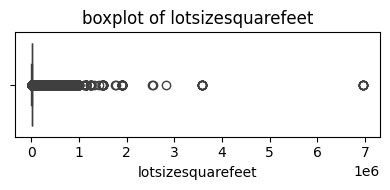

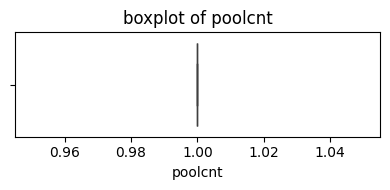

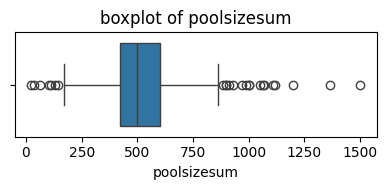

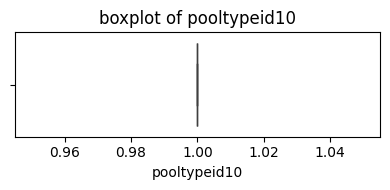

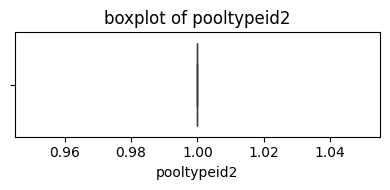

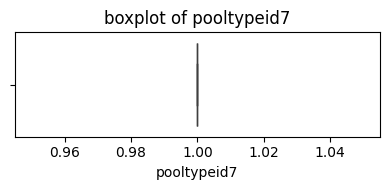

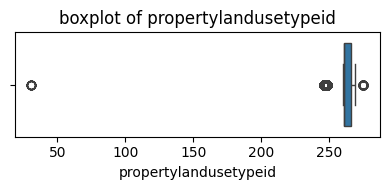

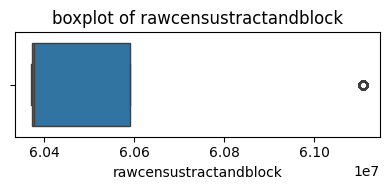

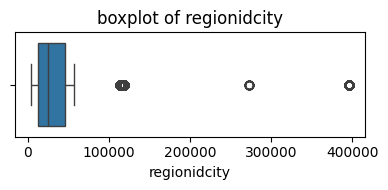

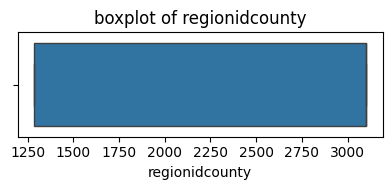

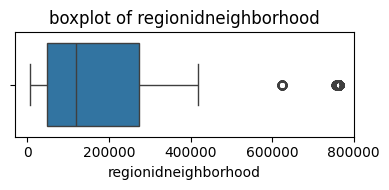

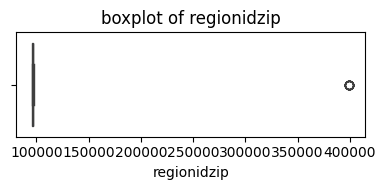

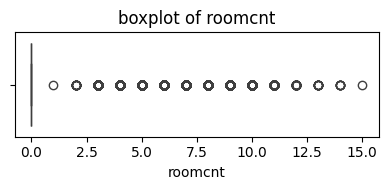

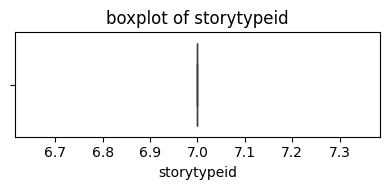

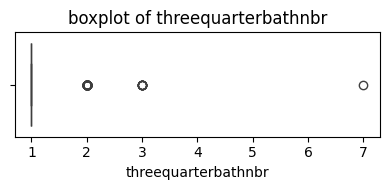

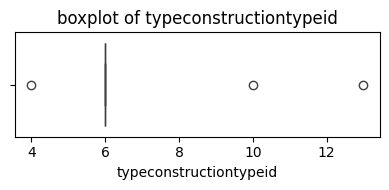

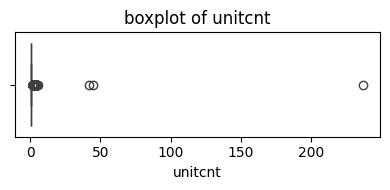

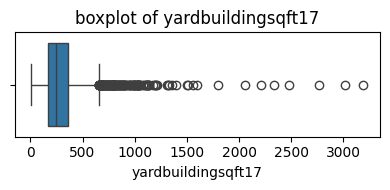

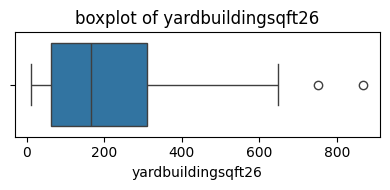

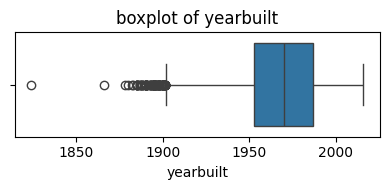

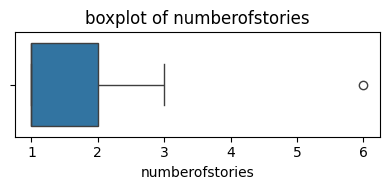

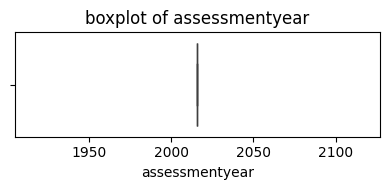

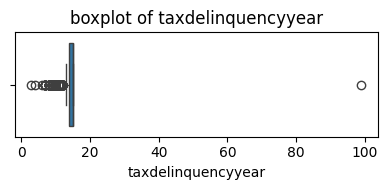

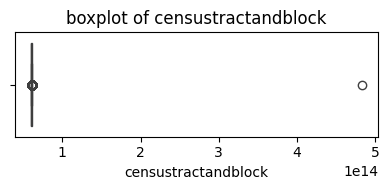

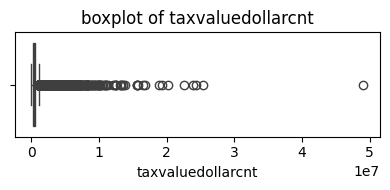

In [150]:
# individual box plots for each numeric feature 

num_cols = df.select_dtypes(include='number').columns

for col in num_cols:
    plt.figure(figsize=(4, 2))
    sns.boxplot(x=df[col])
    plt.title(f'boxplot of {col}')
    plt.xlabel(col)
    plt.tight_layout()
    plt.show()

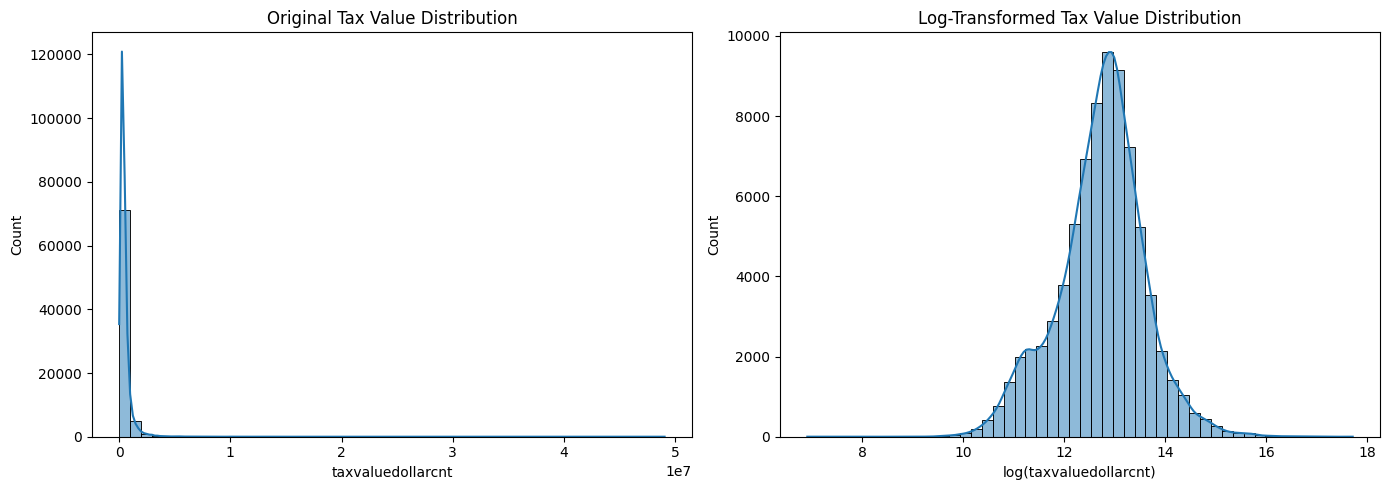

In [151]:
# plot for target value only 

# log-transform
df['log_taxvalue'] = np.log1p(df['taxvaluedollarcnt'])

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# original distribution of target
sns.histplot(df['taxvaluedollarcnt'], bins=50, kde=True, ax=axes[0])
axes[0].set_title('Original Tax Value Distribution')
axes[0].set_xlabel('taxvaluedollarcnt')

# log-transformed distribution
sns.histplot(df['log_taxvalue'], bins=50, kde=True, ax=axes[1])
axes[1].set_title('Log-Transformed Tax Value Distribution')
axes[1].set_xlabel('log(taxvaluedollarcnt)')

plt.tight_layout()
plt.show()

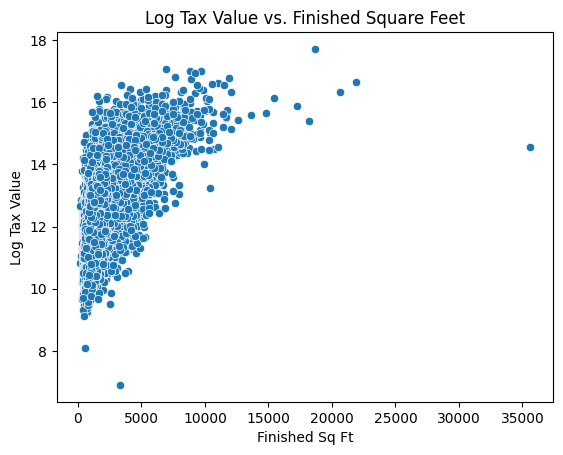

In [152]:
# 1. Square Footage v. Log-Transformed Tax Value
sns.scatterplot(x='calculatedfinishedsquarefeet', y='log_taxvalue', data=df)
plt.title('Log Tax Value vs. Finished Square Feet')
plt.xlabel('Finished Sq Ft')
plt.ylabel('Log Tax Value')
plt.show()

#### **2.B Discussion:** Describe in a paragraph what you learned in your detailed examination of the features you explored:
- What is the distribution (normal, exponential, etc.) if any?
- Any problems (e.g., outliers, any odd characteristics)?
- Anything else interesting? Why did you choose it?


The distribution of the the count based features are skewed right and tend to cluster around typical, lower, values. When looking at the box plots of the numeric features, there are outliers that need to be cleaned up. Some outliers could make sense because there are rare properties that have lots of bedrooms and lots of bathrooms, these are usually very expensive private properties. The box plot of tax value by bathroom count was interesting because we see that average tax value increases are the number of bathrooms increases. The target variable, tax value, is heavily skewed right. Log transforming the target value helps stabalize the variance and bring it to a normal distribution. This will help with modeling to prevent bias. Box plots were primarly chosen because it helps visualize outliers as well as average/typical values. 

## Part 3:  Clean the Data: Drop, Impute, and Encode [6 pts]



**Important Notes:**
- You should review your Homework 4 before doing this section!
- Create new names for modified data at each stage to avoid problems with global variables.
- Whenever possible, write functions for all data transformations you apply, for these reasons:
    - So you can easily prepare the data the next time you get a fresh dataset
    - So you can apply these transformations in future projects
    - To clean and prepare new data instances once your solution is live
    - To make it easy to treat your preparation choices as hyperparameters
    - [To apply the same transformations to your test set if train/test split already done -- not applicable here]

### Part 3.A: Drop features you judge to be unsuitable for the regression task

Your call, based on any research you can do to understand the feature (hopefully IRL you would have a domain expert to help with this, but do your best).   

Note: Do not drop features because of too many missing values, that's the next task! 

In [153]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 77613 entries, 0 to 77612
Data columns (total 56 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   parcelid                      77613 non-null  int64  
 1   airconditioningtypeid         25007 non-null  float64
 2   architecturalstyletypeid      207 non-null    float64
 3   basementsqft                  50 non-null     float64
 4   bathroomcnt                   77579 non-null  float64
 5   bedroomcnt                    77579 non-null  float64
 6   buildingclasstypeid           15 non-null     float64
 7   buildingqualitytypeid         49809 non-null  float64
 8   calculatedbathnbr             76963 non-null  float64
 9   decktypeid                    614 non-null    float64
 10  finishedfloor1squarefeet      6037 non-null   float64
 11  calculatedfinishedsquarefeet  77378 non-null  float64
 12  finishedsquarefeet12          73923 non-null  float64
 13  f

In [154]:
# removing some of the id columns because we don't know what each of their value IDs actually mean but they also have a lot of nulls anyways
cols_to_drop = [ 'architecturalstyletypeid', 'buildingclasstypeid',  'decktypeid', 'typeconstructiontypeid', 'storytypeid' , 'buildingqualitytypeid', 'yearbuilt', 'propertyzoningdesc',
                     'pooltypeid10', 'pooltypeid2', 'pooltypeid7', 'propertylandusetypeid',  'regionidneighborhood', 'propertycountylandusecode']

df.drop(columns=cols_to_drop, inplace=True)

#### **3.A Discussion:** Justify in a paragraph your decisions about which features to drop. 


A lot of the columns are ID columns and we are not sure what the value of the IDs actually mean. It seems like these IDs and codes are a combination of numbers and letters that we don't know what they represent. So we are dropping these features for a regression task because they don't seem to be meaningful values. We assume that each ID value or Code value would represent some categorical meaning, but we don't know so we'll just drop it. There are also a lot of unique values of the IDs and codes, so it would have been too many categorical features to encode from. We also dropped some of the pool columns because they seem to be redundant and invaluable compared to the other pool features.

### Part 3.B: Drop **features** with "too many" null values

Your code in the next cell(s). Make a judgement call about what "too many" means and briefly describe your reasoning in the discussion.   

Note: "Too many" may depend on what the non-null values look like, be sure to investigate carefully. 

In [155]:
percent_missing = df.isnull().mean() * 100
percent_missing = percent_missing.sort_values(ascending= False)

# dropping columns with more than 90% null 
drop_nulls = percent_missing[percent_missing > 90].index.tolist()
drop_nulls

['finishedsquarefeet13',
 'basementsqft',
 'yardbuildingsqft26',
 'fireplaceflag',
 'finishedsquarefeet6',
 'poolsizesum',
 'hashottuborspa',
 'yardbuildingsqft17',
 'taxdelinquencyyear',
 'taxdelinquencyflag',
 'finishedsquarefeet15',
 'finishedsquarefeet50',
 'finishedfloor1squarefeet']

In [156]:
# keeping these although they have more than 90% null because their null values could carry signal, for example the null in fireplaceflag would mean there is no fireplace 
keep_cols = ['fireplaceflag', 'decktypeid', 'poolsizesum', 'hashottuborspa', 'taxdelinquencyflag']

drop_cols = [col for col in drop_nulls if col not in keep_cols]

df.drop(columns=drop_cols, inplace=True)


In [157]:
percent_missing = df.isnull().mean() * 100
percent_missing = percent_missing.sort_values(ascending= False)
percent_missing

fireplaceflag                   99.778388
poolsizesum                     98.880342
hashottuborspa                  98.017085
taxdelinquencyflag              96.263513
fireplacecnt                    89.320088
threequarterbathnbr             86.978985
poolcnt                         79.160708
numberofstories                 77.324675
airconditioningtypeid           67.779882
garagetotalsqft                 67.118910
garagecarcnt                    67.118910
heatingorsystemtypeid           36.130545
unitcnt                         34.672027
lotsizesquarefeet               10.683777
finishedsquarefeet12             4.754358
regionidcity                     1.940397
fullbathcnt                      0.837489
calculatedbathnbr                0.837489
censustractandblock              0.362053
calculatedfinishedsquarefeet     0.302784
regionidzip                      0.108229
taxvaluedollarcnt                0.045096
log_taxvalue                     0.045096
longitude                        0

#### **3.B Discussion:** In a paragraph, explain your decision about which features were dropped

We decided top drop features with more than 90% null. When looking at the columns with 90% null, where majority of the columns had 99% null they were no hesitation to drop them because that is almost the entire dataset thats null. For the id columns that also had more than 90% null, we were okay with dropping them because we didn't know what their unique ID values represent anyways. We decided to keep some of the columns despite them having a lot of nulls because we thought that they weren't true nulls, we thought that blank or null values would indicate a 0 value or false value instead. We are going to encode these columns in the future. 

### Part 3.C: Drop Problematic **samples** 

There could be several reasons why you might want to drop a sample:
- It has  "too many" null values 
- It has a null value in the target
- It contains outliers, especially in the target



Your code in the next cell(s). Make a judgement call about which samples should be dropped and briefly describe your reasoning in the discussion.   


In [158]:
# removing samples with outliers in the target 
# there are 5186 samples removed due to outliers 

Q1 = df['taxvaluedollarcnt'].quantile(0.25)
Q3 = df['taxvaluedollarcnt'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

outliers = df[(df['taxvaluedollarcnt'] < lower_bound) | (df['taxvaluedollarcnt'] > upper_bound)]
num_outliers = outliers.shape[0]
num_outliers

5186

In [159]:
df_cleaned = df[(df['taxvaluedollarcnt'] >= lower_bound) & (df['taxvaluedollarcnt'] <= upper_bound)]

In [160]:
# removing samples with null values in the target 

df = df.dropna(subset=['taxvaluedollarcnt'])


In [161]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 77578 entries, 0 to 77612
Data columns (total 33 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   parcelid                      77578 non-null  int64  
 1   airconditioningtypeid         25007 non-null  float64
 2   bathroomcnt                   77578 non-null  float64
 3   bedroomcnt                    77578 non-null  float64
 4   calculatedbathnbr             76962 non-null  float64
 5   calculatedfinishedsquarefeet  77377 non-null  float64
 6   finishedsquarefeet12          73922 non-null  float64
 7   fips                          77578 non-null  float64
 8   fireplacecnt                  8289 non-null   float64
 9   fullbathcnt                   76962 non-null  float64
 10  garagecarcnt                  25519 non-null  float64
 11  garagetotalsqft               25519 non-null  float64
 12  hashottuborspa                1539 non-null   object 
 13  heatin

In [162]:
# dropping rows with more than 50% nulls (~200 rows)
threshold = int(df.shape[1] * 0.5)
df = df.dropna(thresh=threshold)

In [164]:
# dropping decktypeid and assessment year due to only 1 unique value
df = df.drop(columns=['assessmentyear'])

#### **3.C Discussion:** In a short paragraph, explain your decision about which samples were dropped

We dropped ~200 rows that had more than 50% nulls. This is a very small sample so we are ok with dropping them because its unlikely the would have a big impact on the overall model performance. We also dropped ~5,000 rows with outliers because we saw there were some properties with extremely extreme values that would have skewed the model and negaively affect model accuracy. We also removed samples with null values in the target because those rows would not work with supervised learning.

### Part 3.D: Impute for the remaining missing values

Review the methods for imputation in **Appendix 2** and choose how you will impute the remainder of the missing values. Note:
- Consider whether different methods are justified for different features.
- In the next cells, apply your imputation methods to the dataset so that no null values remain after this step.
- Answer the discussion question.

In [165]:
# imputing the blank values to 0 
count_columns = ['bathroomcnt', 'bedroomcnt', 'fireplacecnt', 'fullbathcnt', 'garagecarcnt', 'poolcnt',  
                        'poolsizesum', 'lotsizesquarefeet', 'garagetotalsqft', 'threequarterbathnbr', 'numberofstories'
                        ]
df[count_columns] = df[count_columns].fillna(0)

In [166]:
null_counts = df.isnull().sum()
null_counts_sorted = null_counts.sort_values(ascending=False)

print(null_counts_sorted)

fireplaceflag                   77315
hashottuborspa                  75948
taxdelinquencyflag              74588
airconditioningtypeid           52480
heatingorsystemtypeid           27916
unitcnt                         26784
finishedsquarefeet12             3565
regionidcity                     1459
calculatedbathnbr                 526
censustractandblock               226
calculatedfinishedsquarefeet      111
regionidzip                        44
fips                                0
parcelid                            0
bedroomcnt                          0
bathroomcnt                         0
longitude                           0
latitude                            0
garagecarcnt                        0
garagetotalsqft                     0
fullbathcnt                         0
fireplacecnt                        0
lotsizesquarefeet                   0
poolcnt                             0
roomcnt                             0
regionidcounty                      0
poolsizesum 

#### **3.D Discussion:**  Describe in a paragraph your decisions about which methods you used to impute missing values in the dataset

For the count based features, we treated the nulls as values for 0. We think this makes sense because we think that housing properties would have at least 1 bathroom and or bedroom. For square footage features, we also treated the nulls for 0. We think this makes sense because we assume that if they don't have that feature, then there would be 0 square footage since it doesn't exist. The same goes for poolsize sum, if the poolsizesum is null we assume there is no pool and so their is 0 size to it. 

### 3.E: Encode the Categorical Features (if any)

You may not have any categorical features. If you do, encode them in the next step. No discussion is necessary. 

In [167]:
# for air conditioning type id and heating or system type id, we used one hot encoding  

df = pd.get_dummies(df, columns=['airconditioningtypeid', 'heatingorsystemtypeid'], 
                    prefix=['ac', 'heat'], dummy_na=True)

df.columns

Index(['parcelid', 'bathroomcnt', 'bedroomcnt', 'calculatedbathnbr',
       'calculatedfinishedsquarefeet', 'finishedsquarefeet12', 'fips',
       'fireplacecnt', 'fullbathcnt', 'garagecarcnt', 'garagetotalsqft',
       'hashottuborspa', 'latitude', 'longitude', 'lotsizesquarefeet',
       'poolcnt', 'poolsizesum', 'rawcensustractandblock', 'regionidcity',
       'regionidcounty', 'regionidzip', 'roomcnt', 'threequarterbathnbr',
       'unitcnt', 'numberofstories', 'fireplaceflag', 'taxdelinquencyflag',
       'censustractandblock', 'taxvaluedollarcnt', 'log_taxvalue', 'ac_1.0',
       'ac_5.0', 'ac_9.0', 'ac_11.0', 'ac_13.0', 'ac_nan', 'heat_1.0',
       'heat_2.0', 'heat_6.0', 'heat_7.0', 'heat_10.0', 'heat_11.0',
       'heat_13.0', 'heat_18.0', 'heat_20.0', 'heat_24.0', 'heat_nan'],
      dtype='object')

In [168]:
cat = df.select_dtypes(include = ["object"]).columns
print(cat)

Index(['hashottuborspa', 'fireplaceflag', 'taxdelinquencyflag'], dtype='object')


In [169]:
#encoding hashottuborspa to numerical 
df["hashottuborspa"] = df["hashottuborspa"].apply( lambda x: 1 if str(x).strip().upper() == 'TRUE' else 0 )
#
#encoding fireplaceflg to numerical 
df["fireplaceflag"] = df["fireplaceflag"].apply( lambda x: 1 if str(x).strip().upper() == 'TRUE' else 0 )

#encoding taxdelinquencyflag to numerical 
df["taxdelinquencyflag"] = df["taxdelinquencyflag"].apply( lambda x: 1 if str(x).strip().upper() == 'Y' else 0 )

In [170]:
df["hashottuborspa"].value_counts()

hashottuborspa
0    75948
1     1539
Name: count, dtype: int64

In [171]:
df["fireplaceflag"].value_counts()

fireplaceflag
0    77315
1      172
Name: count, dtype: int64

In [174]:
df["taxdelinquencyflag"].value_counts()

taxdelinquencyflag
0    74588
1     2899
Name: count, dtype: int64

## Part 4:  Investigate Feature Relationships  [6 pts]

In this part, we will investigate the feature relationships as a way of understanding the data.  In the next part, we'll investigate potential feature engineering opportunities.

**Note:**  We won't be committing to any changes to the data until Milestone 2, as our choice of transformations will very much depend on the model we're building. But investigating these aspects of the data is an essential step in the first stages of our project. 

### Part 4.A:

   - Compute and analyze pairwise correlations using a correlation matrix.
   - Compute the F-statistic for all features for a better view of the relationships (displaying them in a bar chart would be useful as well). 
   - Identify features with strong correlations or notable relationships that may impact model performance.
   - Investigate forward and backward feature selection
        - Run these algorithms to investigate possible feature selection (don't commit to any selections yet)

Your code below, in multiple cells with descriptive comments. 

In [175]:
# correlation table 
corr_matrix = df.corr(numeric_only= True)
print(corr_matrix)

                              parcelid  bathroomcnt  bedroomcnt  \
parcelid                      1.000000     0.009998    0.014717   
bathroomcnt                   0.009998     1.000000    0.632905   
bedroomcnt                    0.014717     0.632905    1.000000   
calculatedbathnbr             0.015775     1.000000    0.618290   
calculatedfinishedsquarefeet  0.027237     0.772864    0.631463   
finishedsquarefeet12          0.036171     0.803920    0.661780   
fips                          0.491438     0.016921    0.036246   
fireplacecnt                  0.287330     0.105921    0.135218   
fullbathcnt                  -0.030732     0.984396    0.626969   
garagecarcnt                  0.407948     0.145965    0.141978   
garagetotalsqft               0.311988     0.196214    0.257290   
hashottuborspa                0.055642     0.166109    0.119785   
latitude                     -0.177040     0.025368    0.068791   
longitude                    -0.014349    -0.022904   -0.00723

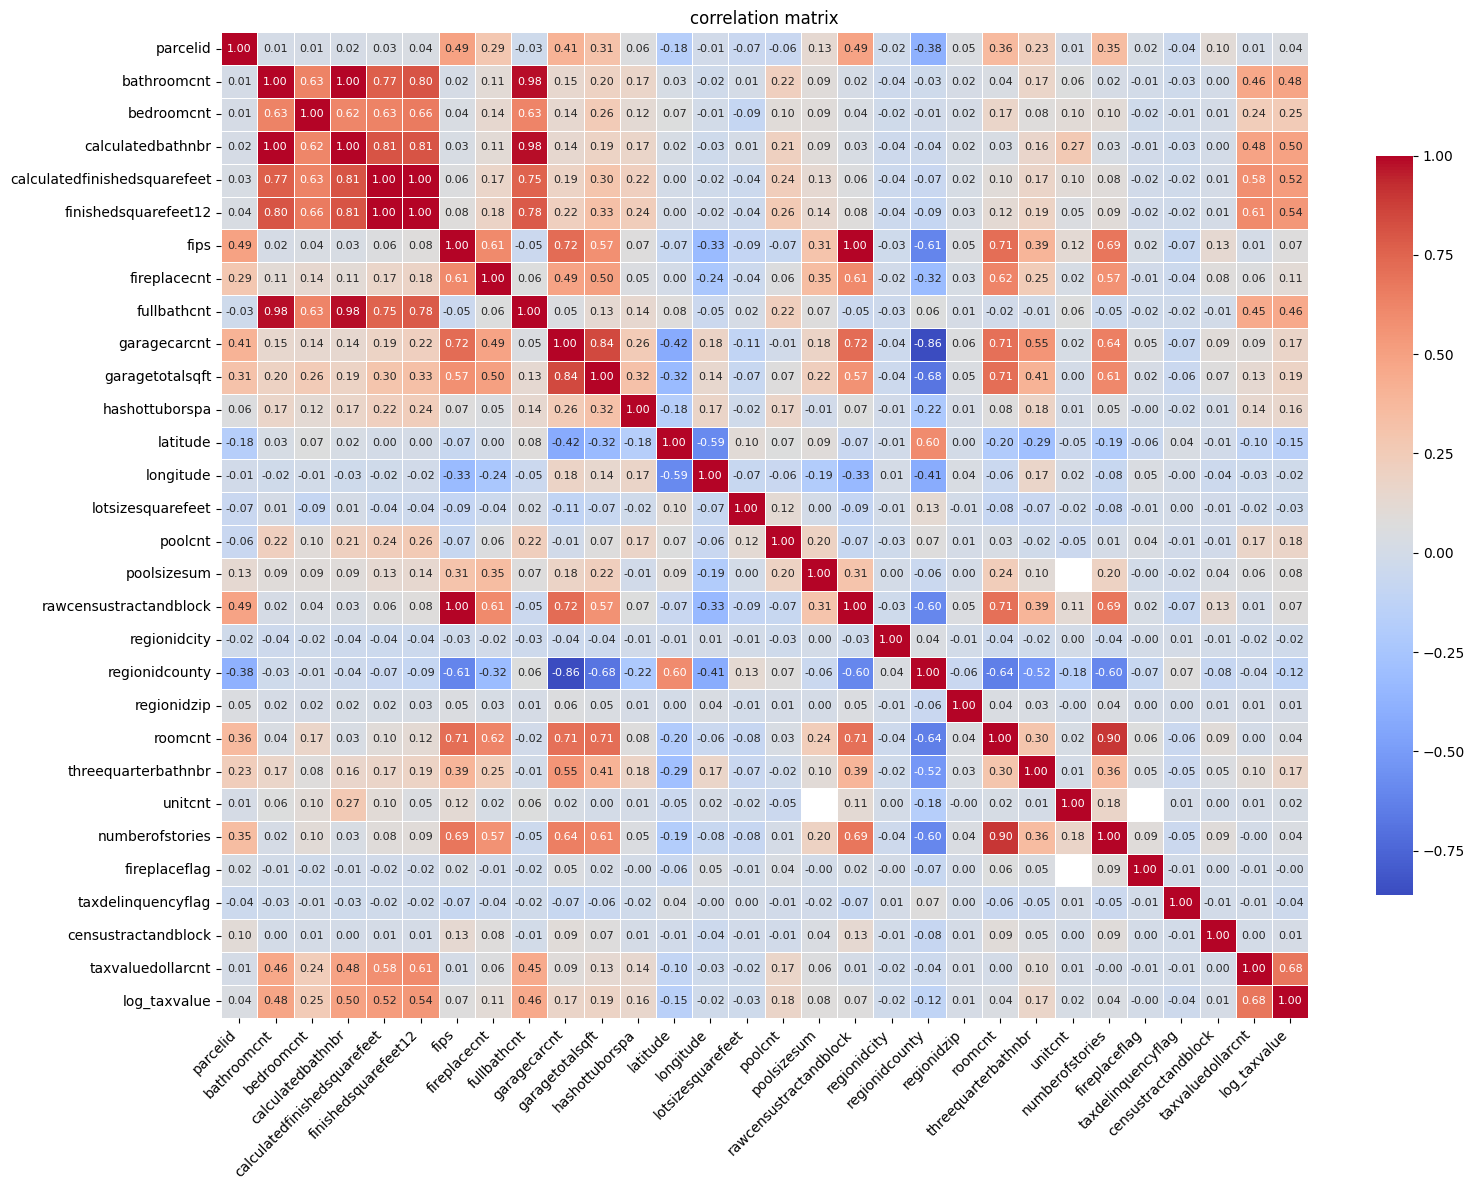

In [176]:
# plotting correlation matrix
cols = [col for col in df.columns if col.startswith('ac_') or col.startswith('heat_')]
df_filtered = df.drop(columns=cols)

corr_matrix = df_filtered.corr(numeric_only=True)

plt.figure(figsize=(16, 12))
sns.heatmap(corr_matrix,annot=True, fmt=".2f",cmap='coolwarm', linewidths=0.5,annot_kws={"size": 8},cbar_kws={"shrink": 0.75})
plt.title("correlation matrix")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


In [177]:
# correlation against the target
target_corr = corr_matrix['taxvaluedollarcnt'].drop('taxvaluedollarcnt')
target_corr.sort_values(ascending=False)

log_taxvalue                    0.683351
finishedsquarefeet12            0.606334
calculatedfinishedsquarefeet    0.583169
calculatedbathnbr               0.484823
bathroomcnt                     0.463004
fullbathcnt                     0.451096
bedroomcnt                      0.240563
poolcnt                         0.166008
hashottuborspa                  0.141637
garagetotalsqft                 0.132314
threequarterbathnbr             0.102032
garagecarcnt                    0.089123
fireplacecnt                    0.056169
poolsizesum                     0.055312
regionidzip                     0.014582
unitcnt                         0.007422
parcelid                        0.006781
fips                            0.006510
rawcensustractandblock          0.005897
roomcnt                         0.001948
censustractandblock             0.001587
numberofstories                -0.001568
fireplaceflag                  -0.007541
taxdelinquencyflag             -0.009639
lotsizesquarefee

/tmp/ipykernel_1950/2505147692.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=target_correlation.values, y=target_correlation.index, palette='coolwarm')


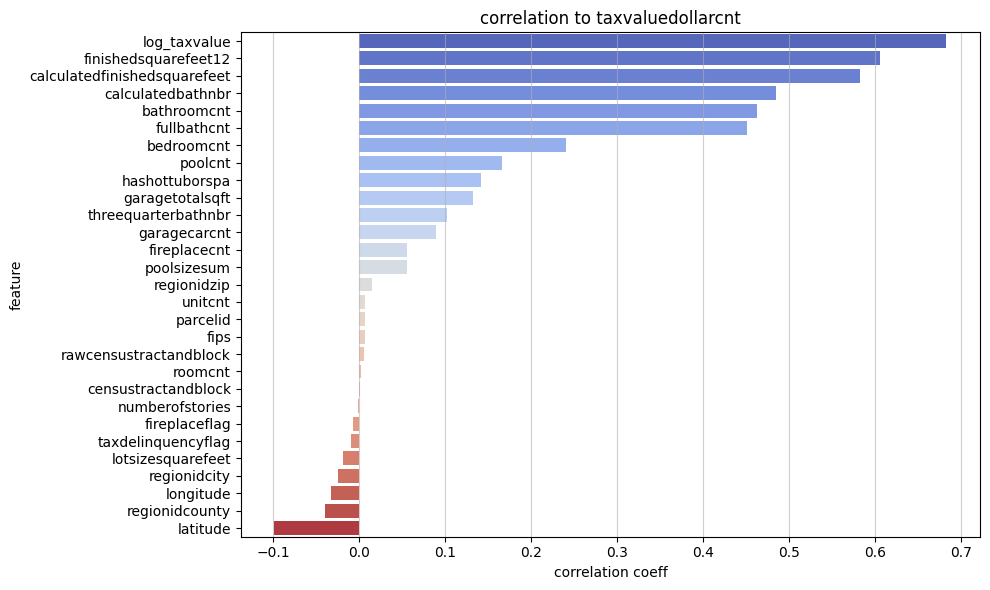

In [178]:
#plotting correlation against target only
target_correlation = target_corr.sort_values(ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x=target_correlation.values, y=target_correlation.index, palette='coolwarm')
plt.title("correlation to taxvaluedollarcnt")
plt.xlabel("correlation coeff")
plt.ylabel("feature")
plt.grid(True, axis='x', alpha =0.6)
plt.tight_layout()
plt.show()

In [179]:
## calculate f statistic 
df = df.dropna()
x = df.drop(columns = 'log_taxvalue')
y = df["log_taxvalue"]

f, p = f_regression(x,y)

f_df = pd.DataFrame( { "feature" : x.columns, "f-value": f, "p value": p}).sort_values(by = "f-value", ascending =False)

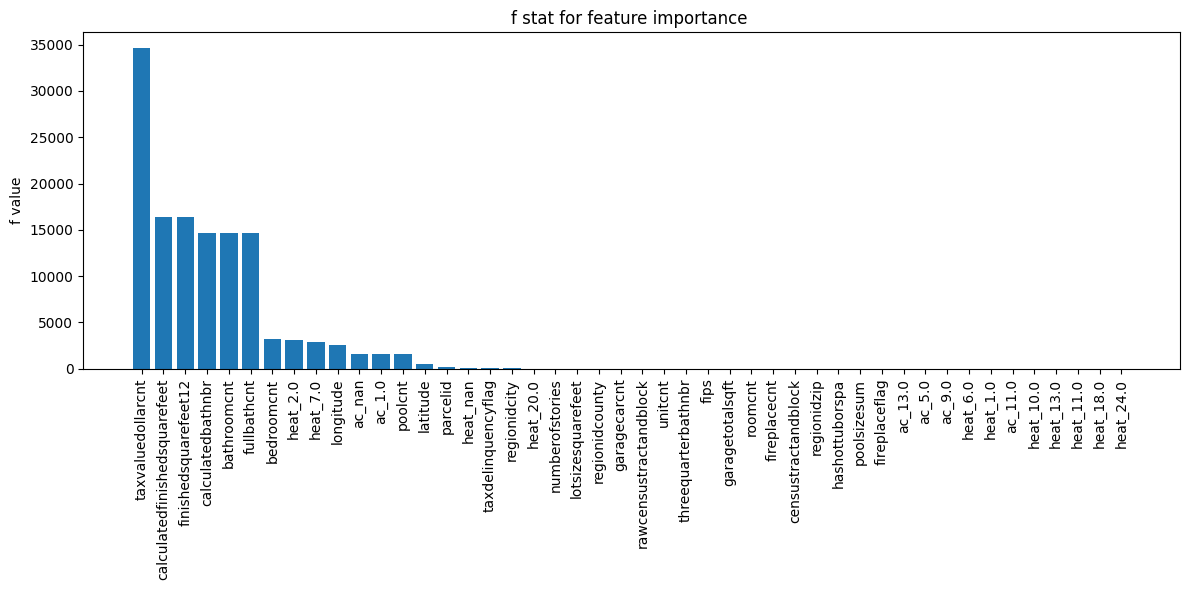

In [180]:
plt.figure(figsize=(12, 6))
plt.bar(f_df["feature"], f_df["f-value"])
plt.xticks(rotation=90)
plt.ylabel("f value")
plt.title("f stat for feature importance ")
plt.tight_layout()
plt.show()


In [181]:

model = LinearRegression()

# forward selection
sfs_forward = SequentialFeatureSelector(model, n_features_to_select='auto', direction='forward')
sfs_forward.fit(x, y)
forward_features = x.columns[sfs_forward.get_support()]

# backward selection
sfs_backward = SequentialFeatureSelector(model, n_features_to_select='auto', direction='backward')
sfs_backward.fit(x, y)
backward_features = x.columns[sfs_backward.get_support()]
print("top f stats features:\n", f_df.head())
print("\nfoward selection features:\n", list(forward_features))
print("\nbackward selection features:\n", list(backward_features))

top f stats features:
                          feature       f-value  p value
28             taxvaluedollarcnt  34594.597882      0.0
4   calculatedfinishedsquarefeet  16420.938868      0.0
5           finishedsquarefeet12  16420.938868      0.0
3              calculatedbathnbr  14676.247933      0.0
1                    bathroomcnt  14676.247933      0.0

foward selection features:
 ['parcelid', 'bathroomcnt', 'calculatedbathnbr', 'calculatedfinishedsquarefeet', 'finishedsquarefeet12', 'fips', 'fullbathcnt', 'latitude', 'longitude', 'lotsizesquarefeet', 'poolcnt', 'poolsizesum', 'rawcensustractandblock', 'regionidcity', 'threequarterbathnbr', 'taxdelinquencyflag', 'taxvaluedollarcnt', 'ac_1.0', 'ac_5.0', 'heat_2.0', 'heat_6.0', 'heat_20.0', 'heat_24.0']

backward selection features:
 ['parcelid', 'bathroomcnt', 'calculatedbathnbr', 'finishedsquarefeet12', 'fips', 'fireplacecnt', 'fullbathcnt', 'garagecarcnt', 'garagetotalsqft', 'latitude', 'longitude', 'lotsizesquarefeet', 'poolcnt',

#### **4.A Discussion:**  Describe in a paragraph what you see in the feature relationships and correlations.

Pay particular attention to especially interesting and/or strongly correlated feature relationships. 
 How do the different methods for seeing relationships compare? Do they agree or disagree?



The count based features were strongly correlated with one another which makes sense because properties with more bedrooms usually have more bathrooms (or more rooms in general). I think it also makes sense that the top important features are the calculated square feet, bedroom features, and bathroom features. This suggests that larger properties with more area and rooms have higher tax value. I also noticed that poolcnt is up there as well, which makes sense also because typically properties with a pool have higher tax value. Seeing the encoded heat features being important is also interesting because it seems like the properties value heating more than air conditioning, since we encoded both heat and airconditioning id. Its also interesting to see that some regional features like the zip codes are important, which makes sense because location is a popular consideration in tax value. 
The correlation matrix, f stat, and forward and backward selection mostly agree with the most valuable or important features to predicting taxvalue. Backward selection do pull some features that were less noticably important such as fips.

### Part 4.B:  2-Dimensional Visualizations for Interesting Patterns  
   - Select three (3) pairs of features that exhibit meaningful relationships based on your previous analysis. 
   - Create 2D scatter plots or density plots to explore interactions between these features.  
   - Provide brief interpretations of any observed patterns or trends. 

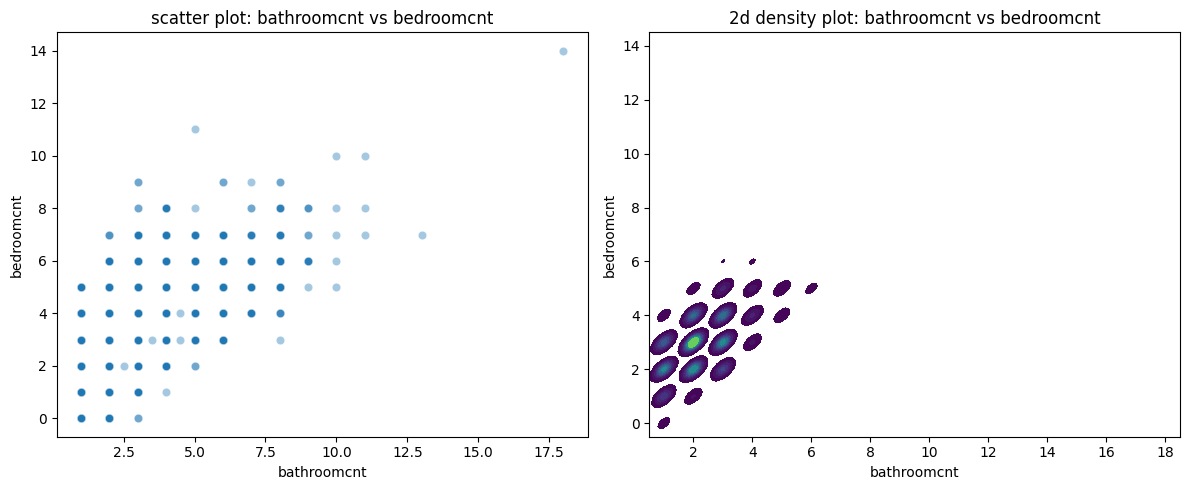

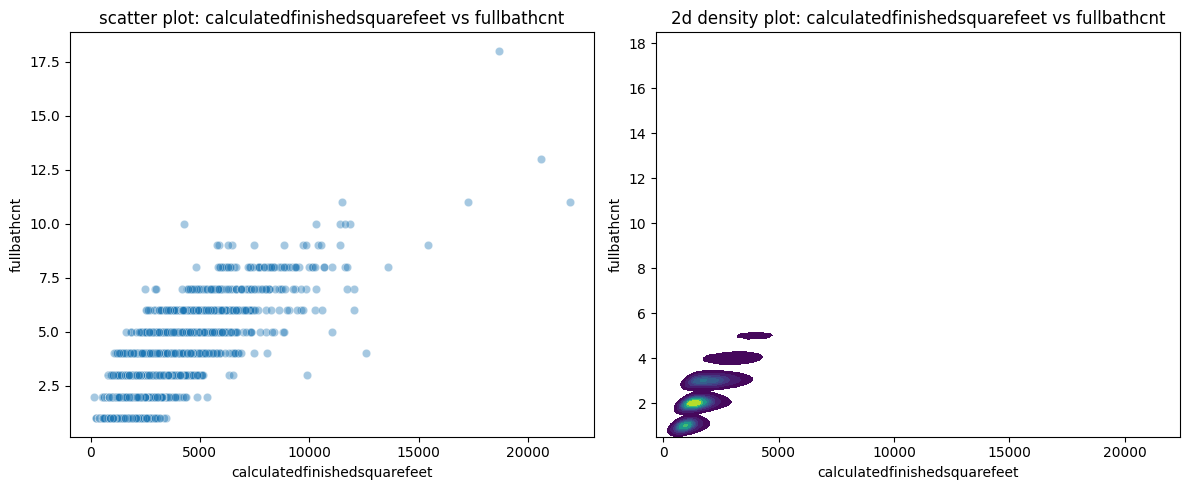

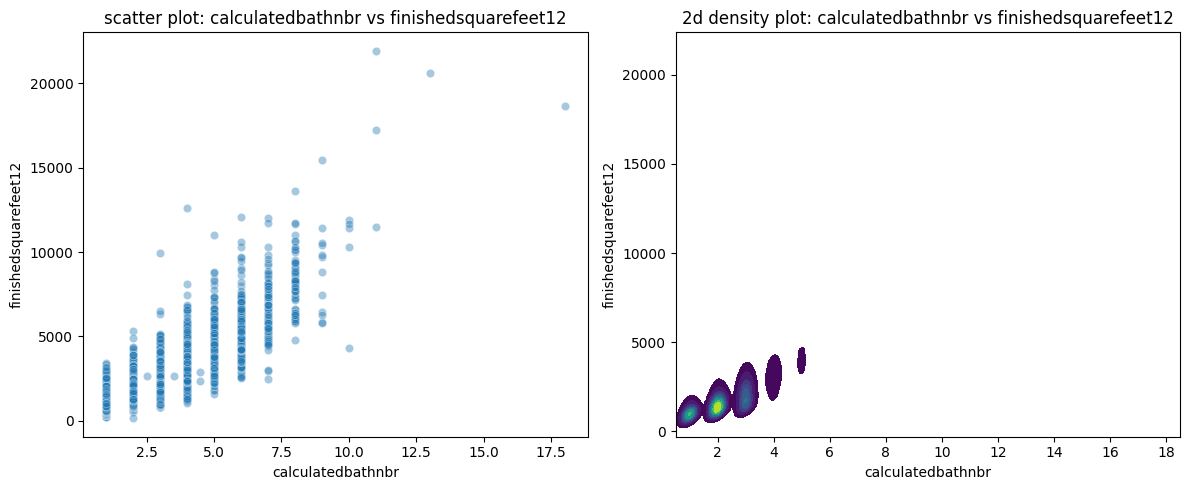

In [182]:
pairs = [
    ("bathroomcnt", "bedroomcnt"),
    ("calculatedfinishedsquarefeet", "fullbathcnt"),
    ("calculatedbathnbr", "finishedsquarefeet12")
]

for x, y in pairs:
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    sns.scatterplot(data=df, x=x, y=y, alpha=0.4)
    plt.title(f"scatter plot: {x} vs {y}")

    plt.subplot(1, 2, 2)
    sns.kdeplot(data=df, x=x, y=y, fill=True, cmap="viridis", thresh=0.05)
    plt.title(f"2d density plot: {x} vs {y}")

    plt.tight_layout()
    plt.show()



#### **4.B Discussion:** Provide brief interpretations of any observed patterns or trends.


From the top features we observed in the previous part, we selected 3 pairs to see how they interact with eachother. The 3 pairs of top feature importance are postively correlated to one another which makese sense because larger square footage of the property would allow for more rooms such as bath and bedrooms. They are each individually positivelyy correlated to the target value. For bedroom and bathroom count, the density plot shows multiple highly dense spots. Its usualy for proporties to be 1 bed 1 bath, 2 bed 1 bath, 3 bed 2 bath ... and etc. These typical property layouts seem to be more dense. 

## Part 5:  Feature Engineering: Investigate various transformations to better expose the underlying data patterns to machine learning algorithms. [6 pts]

**Important Notes:**  
- This last part is a bit open ended, since there is a huge variety of feature engineering techniques, most of which won't be useful for your particular dataset. 
- Understand that you can't evaluate the final usefulness of these transformations
until you choose a model, and  models may respond differently to various transformations or obviate some transformations (e.g., ensemble methods already do feature selection). 
- Therefore, write your transformations as functions or otherwise be prepared
to choose later on which transformations may be necessary. 

**Investigate feature engineering, where appropriate:**

- Feature scaling: standardize or normalize features as necessary
- Decompose features (e.g., categorical into One-Hot feature sequence, date/time into two features data and time, etc.).
- Add promising transformations of features
    - Exponential $\exp(x_i)$ or logarithmic $\log(x_j)$
    - Polynomial features  ( $x_i^2$, $x_i - x_j$), products ($x_i*x_j$), or ratios ($x_i/x_j$)

**ToDo:**
- Pick at least three transformations to try.
- Try each one and evaluate its effect using correlations or F-scores or a feature selection algorithm.
- Answer the discussion question. 

In [183]:
from sklearn.feature_selection import f_classif

In [184]:
feature_cols = ['bathroomcnt', 'bedroomcnt', 'calculatedfinishedsquarefeet', 'finishedsquarefeet12', 'calculatedbathnbr', 'fullbathcnt']

# log transforming the features 
for col in feature_cols:
    df[f'log_{col}'] = np.log1p(df[col])

# square transforming the features
for col in feature_cols:
    df[f'sq_{col}'] = df[col] ** 2

# creating interaction features 
df['bathroom_bedroom_interaction'] = df['bathroomcnt'] * df['bedroomcnt']
df['finishedsqft_calcfinisheddsqft_interaction'] = df['finishedsquarefeet12'] * df['calculatedfinishedsquarefeet']

transformed_features = (
    feature_cols +
    [f'log_{col}' for col in feature_cols] +
    [f'sq_{col}' for col in feature_cols] +
    ['bathroom_bedroom_interaction', 'finishedsqft_calcfinisheddsqft_interaction']
)

/tmp/ipykernel_1950/3118683928.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[f'log_{col}'] = np.log1p(df[col])
/tmp/ipykernel_1950/3118683928.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[f'log_{col}'] = np.log1p(df[col])
/tmp/ipykernel_1950/3118683928.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/use

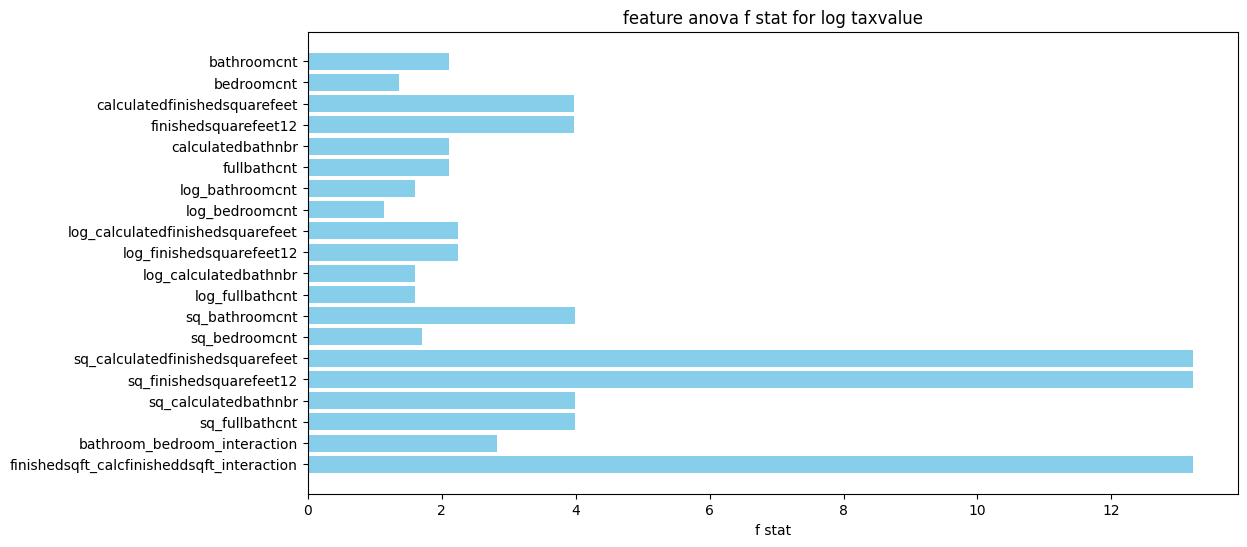

bathroomcnt: F=2.11, p=0.0000e+00
bedroomcnt: F=1.36, p=8.1822e-99
calculatedfinishedsquarefeet: F=3.98, p=0.0000e+00
finishedsquarefeet12: F=3.98, p=0.0000e+00
calculatedbathnbr: F=2.11, p=0.0000e+00
fullbathcnt: F=2.11, p=0.0000e+00
log_bathroomcnt: F=1.60, p=4.1815e-224
log_bedroomcnt: F=1.15, p=7.5817e-22
log_calculatedfinishedsquarefeet: F=2.25, p=0.0000e+00
log_finishedsquarefeet12: F=2.25, p=0.0000e+00
log_calculatedbathnbr: F=1.60, p=4.1815e-224
log_fullbathcnt: F=1.60, p=5.0987e-224
sq_bathroomcnt: F=3.99, p=0.0000e+00
sq_bedroomcnt: F=1.71, p=9.6344e-289
sq_calculatedfinishedsquarefeet: F=13.22, p=0.0000e+00
sq_finishedsquarefeet12: F=13.22, p=0.0000e+00
sq_calculatedbathnbr: F=3.99, p=0.0000e+00
sq_fullbathcnt: F=3.99, p=0.0000e+00
bathroom_bedroom_interaction: F=2.82, p=0.0000e+00
finishedsqft_calcfinisheddsqft_interaction: F=13.22, p=0.0000e+00


In [185]:
X = df[transformed_features].fillna(0)
y = df['log_taxvalue']

## calculate f score

f_values, p_values = f_classif(X, y)

plt.figure(figsize=(12,6))
plt.barh(transformed_features, f_values, color='skyblue')
plt.xlabel('f stat')
plt.title('feature anova f stat for log taxvalue') 
plt.gca().invert_yaxis()
plt.show()

for feat, f_val, p_val in zip(transformed_features, f_values, p_values):
    print(f"{feat}: F={f_val:.2f}, p={p_val:.4e}")


#### **5 Discussion:** Describe in a paragraph why you chose these transformations and what you observed. 


we chose to apply log and square transformations as well as creating new interaction features. This is to capture potential nonlinear relationships as well as identifying the cobined effects between features and the target variable. We saw from the density plot that bathroom and bedroom has multiple dense spots, so we decided to create an interaction feature for them. We tried log transformation to bring back the skewed features back to a normal distributino to reduce noise and bias. The results showed that the squared features had a higher f stat than both the original and log transformations, which mean that the square features have stronger power in explaining variance. Interaction terms also show high f stat, showing that the combined features are valuable than just the individual features. 


## **Appendix 1: Features of the Zillow Dataset**  

0. **parcelid**: Unique identifier for the property parcel.  
1. **airconditioningtypeid**: Identifier for the type of air conditioning installed.  
2. **architecturalstyletypeid**: Identifier for the architectural style of the property.  
3. **basementsqft**: Square footage of the basement.  
4. **bathroomcnt**: Number of bathrooms.  
5. **bedroomcnt**: Number of bedrooms.  
6. **buildingclasstypeid**: Identifier for the building framing type (e.g., wood frame, steel frame).  
7. **buildingqualitytypeid**: Numeric value indicating the quality of the building (higher values often indicate better quality).  
8. **calculatedbathnbr**: Calculated number of bathrooms, including fractional bathrooms.  
9. **decktypeid**: Identifier for the type of deck.  
10. **finishedfloor1squarefeet**: Square footage of the finished area on the first floor.  
11. **calculatedfinishedsquarefeet**: Total finished living area square footage.  
12. **finishedsquarefeet12**: Finished living area square footage.  
13. **finishedsquarefeet13**: Perimeter living area square footage.  
14. **finishedsquarefeet15**: Total area.  
15. **finishedsquarefeet50**: Square footage of the finished area on the upper floors.  
16. **finishedsquarefeet6**: Base unfinished and finished area square footage.  
17. **fips**: Federal Information Processing Standards code, uniquely identifying counties and county equivalents.  
18. **fireplacecnt**: Number of fireplaces.  
19. **fullbathcnt**: Number of full bathrooms.  
20. **garagecarcnt**: Number of cars that can fit in the garage.  
21. **garagetotalsqft**: Total square footage of the garage.  
22. **hashottuborspa**: Indicates if the property has a hot tub or spa.  
23. **heatingorsystemtypeid**: Identifier for the type of heating system.  
24. **latitude**: Latitude coordinate of the property.  
25. **longitude**: Longitude coordinate of the property.  
26. **lotsizesquarefeet**: Lot size in square feet.  
27. **poolcnt**: Number of pools on the property.  
28. **poolsizesum**: Total square footage of all pools.  
29. **pooltypeid10**: Identifier for spa or hot tub.  
30. **pooltypeid2**: Identifier for pool with spa or hot tub.  
31. **pooltypeid7**: Identifier for pool without hot tub or spa.  
32. **propertycountylandusecode**: County land use code for the property.  
33. **propertylandusetypeid**: Identifier for the property land use type.  
34. **propertyzoningdesc**: Description of the property's zoning.  
35. **rawcensustractandblock**: Unprocessed census tract and block identifier.  
36. **regionidcity**: Identifier for the city.  
37. **regionidcounty**: Identifier for the county.  
38. **regionidneighborhood**: Identifier for the neighborhood.  
39. **regionidzip**: Identifier for the ZIP code.  
40. **roomcnt**: Total number of rooms.  
41. **storytypeid**: Identifier for the type of stories in the building (e.g., basement, attic).  
42. **threequarterbathnbr**: Number of 3/4 bathrooms (typically includes a shower but no tub).  
43. **typeconstructiontypeid**: Identifier for the type of construction (e.g., frame, masonry).  
44. **unitcnt**: Number of units in the building (e.g., for multi-family properties).  
45. **yardbuildingsqft17**: Square footage of the 17th yard building (e.g., shed).  
46. **yardbuildingsqft26**: Square footage of the 26th yard building.  
47. **yearbuilt**: Year the property was built.  
48. **numberofstories**: Number of stories in the building.  
49. **fireplaceflag**: Indicates if the property has a fireplace.  
50. **assessmentyear**: Year the property was assessed.  
51. **taxdelinquencyflag**: Indicates whether the property’s taxes are delinquent. Often “Y” if taxes are past due; otherwise null/empty.  
52. **taxdelinquencyyear**: The year in which the property’s taxes became delinquent.  
53. **censustractandblock**: A combined identifier for the property’s census tract and block group (part of the U.S. Census geographic hierarchy).  
54. **taxvaluedollarcnt**: Total assessed value of the property (land plus structure) in dollars.  


## Appendix 2: Summary of Basic Imputation Methods
Imputation depends on the data type and context. Below are common techniques for handling missing values.

---

### **1. Simple Imputation (Basic Methods)**
| Method | Best For | Code Example | Pros | Cons |
|--------|---------|--------------|------|------|
| **Drop Missing Values** | Few missing values (<5% of data) | `df.dropna()` | Quick and easy | Can remove valuable data |
| **Mean Imputation** | Normally distributed numerical data | `df.fillna(df.mean())` | Preserves mean; simple | Distorts variance, weak for skewed data |
| **Median Imputation** | Skewed numerical data | `df.fillna(df.median())` | Robust to outliers | May not capture patterns |
| **Mode Imputation** | Categorical features | `df.fillna(df.mode().iloc[0])` | Keeps most common category | Can introduce bias |
| **Constant Value (e.g., 0)** | Special cases (e.g., unknown numerical data) | `df.fillna(0)` | Simple and interpretable | Can mislead model |
| **"Unknown" Category Imputation** (**New Addition**) | Categorical features with missing values | `df.fillna('Unknown')` | Keeps all rows, prevents data loss | May introduce artificial category |

---

### **2. Statistical & Advanced Imputation**
| Method | Best For | Code Example | Pros | Cons |
|--------|---------|--------------|------|------|
| **Interpolation** | Time series, ordered data | `df.interpolate(method='linear')` | Preserves trends | May not work for non-continuous data |
| **K-Nearest Neighbors (KNN)** | Small datasets, patterns in features | `KNNImputer(n_neighbors=5).fit_transform(df)` | Uses similar observations | Computationally expensive |
| **Multivariate Imputation (MICE)** | Complex relationships between variables | `IterativeImputer().fit_transform(df)` | Captures relationships | Slower than mean/median |
| **Regression Imputation** | When missing values depend on other variables | Train regression model to predict missing values | More accurate than mean/median | Risk of overfitting |

---

### **When to Use "Unknown" Category for Categorical Imputation**
✅ **Good for:**
- Categorical features where missing values may indicate meaningful differences.  
- Customer data (e.g., missing survey responses → "No Response").  
- Product categories where missing could be a separate group.  

❌ **Avoid if:**
- The missing category does **not** have a meaningful interpretation.
- The model might learn spurious patterns from an artificial category.

---

### **Which Method to Choose?**
| Scenario | Best Method |
|----------|------------|
| **Few missing values (<5%)** | Drop NaNs (`df.dropna()`) |
| **Numerical & normal distribution** | Mean (`df.fillna(df.mean())`) |
| **Numerical & skewed distribution** | Median (`df.fillna(df.median())`) |
| **Categorical features** | Mode (`df.fillna(df.mode().iloc[0])`) |
| **Categorical with possible meaning in missingness** | "Unknown" Category (`df.fillna('Unknown')`) |
| **Small dataset with patterns** | KNN Imputer (`KNNImputer()`) |
| **Complex relationships between features** | MICE / Iterative Imputer |

